## DeepEntropyScaling Model Demo

In this notebook we show how easy it is to use the DeepEntropyScaling model.
Please install PyTorch and the feos package first.

The example chosen is butanol. Butanol was not included in the model's training data. The model results are therefore pure predictions. Viscosities of alcohols are difficult to predict. In addition, the data in the entropy room is very noisy. Predictions with around or less than 10% MEAD from experimental data are considered remarkable. 

![plots/example_sub.png](plots/example_sub.png)

The entropy subspace of alcohols is very noisy. Around 8% errors occur when all available data is translated into the subspace, a polynomial is fitted and translated back. It is a kind of expected translation loss. Therefore, errors below 8% are not to be expected for butanol (without targeted training in a limited pressure range).

The experimental references are freely available DDB data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json, toml

from deep_entropy_scaling.deep_entropy_scaling import *


### Load PC-SAFT parameters

At first we load the PC-SAFT parameters. The model is optimized using two parameter sets from Esper and Winter. The parameters in these data sets are very similar and follow an internal logic. We recommend relying on parameters from those datasets or parameters that are obtained using the same rules. Especially when parameters are only optimised for one species, they can degenerate. Such parameters do not represent the underlying species properly and are not suited for predictions.

In [2]:
saft = pd.read_csv( "demo_data/saft_paras_demo.csv" )
saft

,names,molarweight,m,sigma,epsilon_k,mu,kappa_ab,epsilon_k_ab,isomeric_smiles
0,butan-1-ol,74.073,3.140383,3.432248,256.079712,0,0.004223,2444.189697,CCCCO


### Load data

Now we can load the data we want to predict viscosities for. We assume SI units i.e. temperature in K and pressure in Pascal. Furthermore we recommend to add state information about what phase a state point belongs to. Here all datapoints are in the liquid phase.

After loading the data we assign PC-SAFT parameters to every sample.

In [3]:
data = pd.read_csv("demo_data/butanol_data.csv")
para_cols = ['molarweight', 'm','sigma', 'epsilon_k', 'kappa_ab','epsilon_k_ab','mu']
for pcol in para_cols:
    data[pcol] = saft[pcol].iloc[0]

data = data.apply( get_resd_entropy , axis=1 )
data = data.apply( get_CE_viscosity_reference_new , axis=1 )
    
data.head()

,temperature,pressure,viscosity,state,Reference,density,names,molarweight,m,sigma,epsilon_k,kappa_ab,epsilon_k_ab,mu,resd_entropy,molar_density,red_temperature,red_density,ln_eta_ref_new
0,203.15,100,109.00,liquid,3,NaN,butan-1-ol,74.073,3.140383,3.432248,256.079712,0.004223,2444.189697,0,5.159781,11928.820963,0.793308,0.290459,-12.221706
1,203.15,5000,110.42,liquid,3,NaN,butan-1-ol,74.073,3.140383,3.432248,256.079712,0.004223,2444.189697,0,5.159796,11928.853816,0.793308,0.290460,-12.221706
2,203.15,10000,112.45,liquid,3,NaN,butan-1-ol,74.073,3.140383,3.432248,256.079712,0.004223,2444.189697,0,5.159811,11928.887339,0.793308,0.290460,-12.221706
3,213.15,100,57.52,liquid,3,NaN,butan-1-ol,74.073,3.140383,3.432248,256.079712,0.004223,2444.189697,0,5.000669,11810.468094,0.832358,0.287577,-12.172179
4,213.15,5000,58.57,liquid,3,NaN,butan-1-ol,74.073,3.140383,3.432248,256.079712,0.004223,2444.189697,0,5.000684,11810.501570,0.832358,0.287578,-12.172179


### Build and Load NN

Finally we can build our NN model with the optimized hyperparmeters. Then we load and apply the model weights.

In [4]:
model_path = "model0/"

with open(model_path+'best_trained_model_paras.toml', 'r') as toml_file:
    model_hyperparas = toml.load( toml_file)
    
with open(model_path+'train_val_test_norm.json', 'r') as json_file:
    train_val_test_norm = json.load( json_file)    

paranet_layer_units = [ int(model_hyperparas["paranet_layer_units"]) ]* model_hyperparas["paranet_layer_no"]
refnet_layer_units  = [ int(model_hyperparas["refnet_layer_units"]) ]* model_hyperparas["refnet_layer_no"]    
    
model = DeepEntropyNet( 7, int(model_hyperparas["num_used_features"]),   
                 paranet_layer_units=paranet_layer_units,
                 refnet_layer_units=refnet_layer_units,
                 batch_norm=model_hyperparas["batch_norm"],
                 use_base=model_hyperparas["use_base"] )    
    
model.load_state_dict(torch.load(model_path+"/best_trained_model.state_dict") ) #, map_location=device))

[7, 50, 50, 6]
[9, 12, 12, 1]

paranet

linear io 7 50
batch_norm size 50
relu
linear io 50 50
batch_norm size 50
relu
linear io 50 6

refnet

linear io 9 12
batch_norm size 12
relu
linear io 12 12
batch_norm size 12
relu
linear io 12 1


<All keys matched successfully>

### Build Dataset

After loading the data we can generate the dataset used for predictions.
Since the neural network operates with normalised inputs, the normalisation rules must be loaded and applied to the dataset. The polynomial features are also added. This all happens automatically.

In [5]:

dataset = DeepEntropyDataset( data, train_val_test_norm, int(model_hyperparas["num_used_features"])-1  )
    

### Predict viscosities

Now we can use the model to predict viscosities. The model predicts the normed log of the viscosity in milli pascal seconds (mPas).

In [6]:
y_pred = model(dataset.X_norm).detach().numpy()

### Compare Predictions with Experimental Results

The predictions can be compared to experimental results. The experimental results units are pascal seconds (Pas). Therefore we need to multiply them by 1000 before we can compare them to the exponential of the predictions.

#### Agreement between prediction and experiment is good.
#### We want to point out that not even one butanol sample was used during model training. We look at predictions.

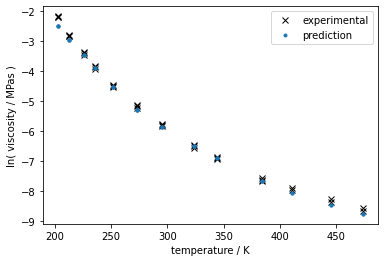

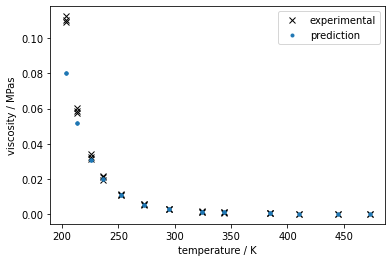

MEAD:  9.2 %


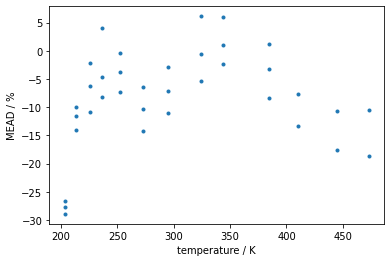

In [7]:
y  = np.squeeze( dataset.unormy(y_pred) )
yy = np.exp( y )
y_exp = data["viscosity"]/1000

plt.plot( data["temperature"], np.log(y_exp), "kx", label="experimental" )
plt.plot( data["temperature"], y, ".", label="prediction" )
plt.legend()
plt.xlabel("temperature / K")
plt.ylabel("ln( viscosity / MPas )")
plt.show()
plt.close()

plt.plot( data["temperature"], y_exp, "kx", label="experimental" )
plt.plot( data["temperature"], yy, ".", label="prediction" )
plt.legend()
plt.xlabel("temperature / K")
plt.ylabel("viscosity / MPas")
plt.show()
plt.close()

dev =   (yy-y_exp) / y_exp

print("MEAD: ", round(np.mean( np.abs(dev) )*100,2), "%" )

plt.plot(data["temperature"], dev*100, ".")
plt.xlabel("temperature / K")
plt.ylabel("MEAD / %")
plt.show()
plt.close()